In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from matplotlib import pyplot as plt
from keras.utils import np_utils
from keras import backend as K
from tensorflow.keras.models import *

%matplotlib inline

2023-05-08 23:42:19.137188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#function of load images
def load_images(dirname, filetype=None, size=None):
    images = []
    filenames = os.listdir(dirname)
    
    if filetype is not None:
        filenames = [filename for filename in filenames if filename.endswith('.' + filetype)]
        
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), cv2.IMREAD_COLOR)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        images.append(image)
    
    return images

In [3]:
#function of preparete images of classification
def prepare_data(normal_images, pneumonia_images, normalize=False, return_y=False):
  
    normal_images = np.array(normal_images) if type(normal_images) == list else normal_images
    pneumonia_images = np.array(pneumonia_images) if type(pneumonia_images) == list else pneumonia_images
        
    X = np.concatenate((normal_images, pneumonia_images), axis=0)
    
    if normalize:
        X = X.astype(np.float32) / 255
    
    if return_y:
        normal_label    = np.zeros(normal_images.shape[0])
        pneumonia_label = np.ones(pneumonia_images.shape[0])
        
        y = np.concatenate((normal_label, pneumonia_label), axis=0)
        
        return X, y
    
    return X

In [4]:
#load images with no pneumonia
normal_images_train = load_images(dirname = 'chest_xray/train/NORMAL',filetype = 'jpeg', size = (128, 128))
normal_images_val   = load_images(dirname = 'chest_xray/val/NORMAL', filetype = 'jpeg', size = (128, 128))
normal_images_test  = load_images(dirname = 'chest_xray/test/NORMAL', filetype = 'jpeg', size = (128, 128))

#load images with pneumonia
pneumonia_images_train = load_images(dirname = 'chest_xray/train/PNEUMONIA', filetype = 'jpeg', size = (128, 128))
pneumonia_images_val   = load_images(dirname = 'chest_xray/val/PNEUMONIA', filetype = 'jpeg',size = (128, 128))
pneumonia_images_test  = load_images(dirname = 'chest_xray/test/PNEUMONIA', filetype = 'jpeg', size = (128, 128))

In [5]:
#dividing datas in train/validation/test and normalization datas too
X_train, y_train = prepare_data(normal_images_train, pneumonia_images_train, normalize=True, return_y=True)

X_val, y_val = prepare_data(normal_images_val, pneumonia_images_val, normalize=True, return_y=True)

X_test, y_test = prepare_data(normal_images_test, pneumonia_images_test, normalize=True, return_y=True)

Text(0.5, 1.0, 'Pneumonia')

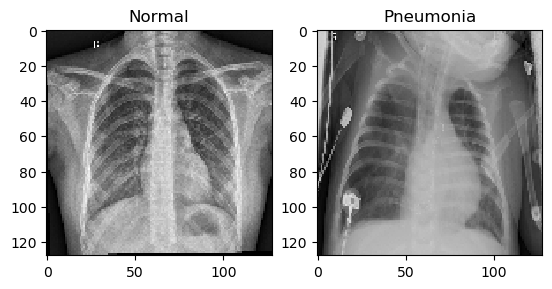

In [6]:
#plot normal image and pneumonia image for visualization
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(normal_images_train[0])
ax1.set_title('Normal')
ax2.imshow(pneumonia_images_train[0])
ax2.set_title('Pneumonia')

In [28]:
#import VGG16 and add final layer
baseModel = tf.keras.applications.VGG16(
                include_top=False,
                weights='imagenet',
                input_tensor=None,
                input_shape=(128,128,3),
                pooling=None,
                classifier_activation="sigmoid",
            )

headModel = Flatten()(baseModel.output)
prediction = Dense(1, activation="sigmoid")(headModel)
model_VGG16 = Model(inputs=baseModel.input, outputs=prediction)

model_VGG16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [29]:
#complile and fit model
model_VGG16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#training model
result_VGG16 = model_VGG16.fit(X_train, y_train, batch_size=32, epochs=10, 
                               validation_data=(X_val, y_val))

Epoch 1/10
163/163 [==============================] - 2914s 18s/step - loss: 0.4772 - accuracy: 0.8023 - val_loss: 1.9865 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 2630s 16s/step - loss: 0.1623 - accuracy: 0.9369 - val_loss: 0.9953 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 2609s 16s/step - loss: 0.1175 - accuracy: 0.9549 - val_loss: 0.3583 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 2591s 16s/step - loss: 0.0898 - accuracy: 0.9668 - val_loss: 0.2098 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 2586s 16s/step - loss: 0.0739 - accuracy: 0.9709 - val_loss: 0.3233 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 2587s 16s/step - loss: 0.0860 - accuracy: 0.9672 - val_loss: 0.1839 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 2662s 16s/step - loss: 0.0943 - accuracy: 0.9651 - val_loss: 1.2410 - val_ac

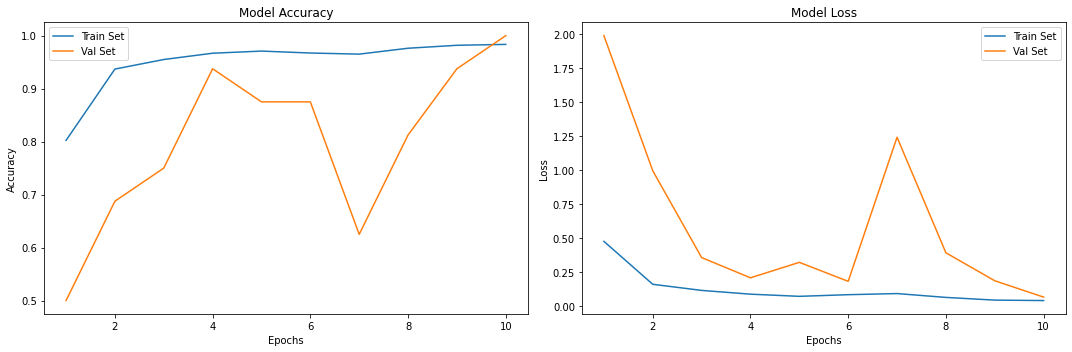

In [56]:
# Plot model performance
acc = result_VGG16.history['accuracy']
val_acc = result_VGG16.history['val_accuracy']
loss = result_VGG16.history['loss']
val_loss = result_VGG16.history['val_loss']
epochs_range = range(1, len(result_VGG16.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
#plt.savefig('figures/plot1.png')
plt.show()

In [7]:
# evaluate test data
#model_VGG16.evaluate(X_test, y_test)

# We save the model
#model_VGG16.save('my_model.h5')

# We load the saved model
model_VGG16 = tf.keras.models.load_model('my_model.h5')

In [9]:
model_VGG16.evaluate(X_test, y_test)

20/20 [==============================] - 95s 5s/step - loss: 1.7394 - accuracy: 0.7596


[1.7393609285354614, 0.7596153616905212]

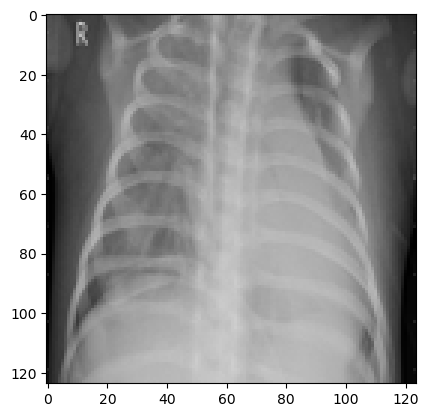

In [59]:
from PIL import Image

img_path = 'chest_xray/test/PNEUMONIA/person161_bacteria_759.jpeg'
img = Image.open(img_path).convert('RGB')
img = img.resize((124, 124))
img_array = np.array(img)

plt.imshow(img_array)
plt.savefig('figures/plot4.png')
plt.show()

# LIME

1/1 [==============================] - 2s 2s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 177ms/step


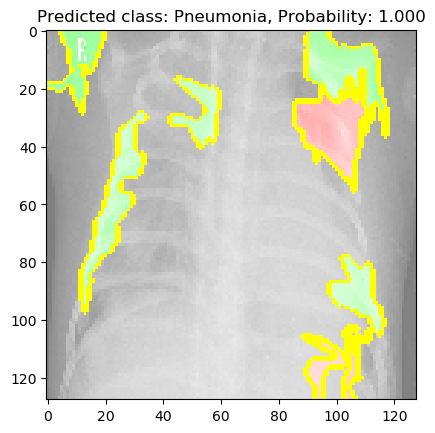

In [60]:
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import keras.backend as K
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Define the class names for the dataset
class_names = ['Pneumonia', 'Normal']

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(128, 128))
    img_array = np.array(img)
    img_array = img_array.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define a function to predict the class probabilities for the input image
def predict_fn(img_array):
    return model_VGG16.predict(img_array)

# Define a function to show the original and the LIME-explained image with its predicted label and probability
def visualize_explanation(img_path, explainer, segmentation_fn):
    img = load_img(img_path, target_size=(128, 128))
    img_array = np.array(img)
    img_array = img_array.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    label = model_VGG16.predict(img_array)
    label = np.argmax(label)
    explanation = explainer.explain_instance(img_array[0], predict_fn, top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=segmentation_fn)
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Predicted class: {class_names[label]}, Probability: {model_VGG16.predict(img_array)[0][label]:.3f}")
    plt.savefig('figures/plot2.png')
    plt.show()

# Define the LIME explainer and the segmentation function
explainer = lime_image.LimeImageExplainer()
segmentation_fn = SegmentationAlgorithm('slic', n_segments=150, compactness=1, sigma=1)

# Apply LIME on a test image and visualize the result
test_img_path = 'chest_xray/test/PNEUMONIA/person161_bacteria_759.jpeg'
visualize_explanation(test_img_path, explainer, segmentation_fn)

# SHAP

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


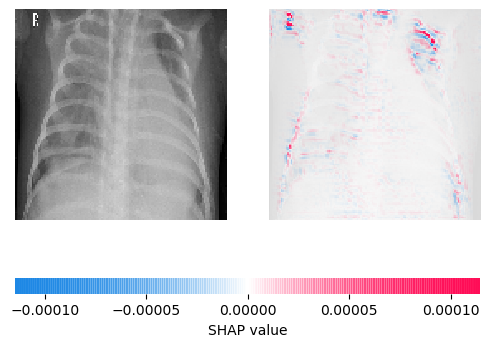

In [59]:
# Import necessary libraries
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(128, 128))
    img_array = np.array(img)
    img_array = img_array.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define a function to predict the class probabilities for the input image
def predict_fn(img_array):
    return model_VGG16.predict(img_array)

# Define the background dataset to use for integrating out features
background = np.zeros((1,128,128,3))

# Create the shap values object using the DeepExplainer class
explainer = shap.DeepExplainer(model_VGG16, background)

# Load the image path and preprocess the image
img_path = 'chest_xray/test/PNEUMONIA/person161_bacteria_759.jpeg'
img_array = preprocess_image(img_path)

# Generate SHAP values for the image
shap_values = explainer.shap_values(img_array)

# Plot the results
shap.image_plot(shap_values, img_array, show=False)
f = plt.gcf()
plt.savefig('figures/plot3.png')

# Integrated Gradients

In [31]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=128, target_width=128)
    return image

baseline = tf.zeros(shape=(128,128,3))

m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

file_name = 'chest_xray/test/PNEUMONIA/person161_bacteria_759.jpeg'
img_name_tensors = read_image(file_name)
interpolated_images = interpolate_images(baseline=baseline, image=img_name_tensors, alphas=alphas)

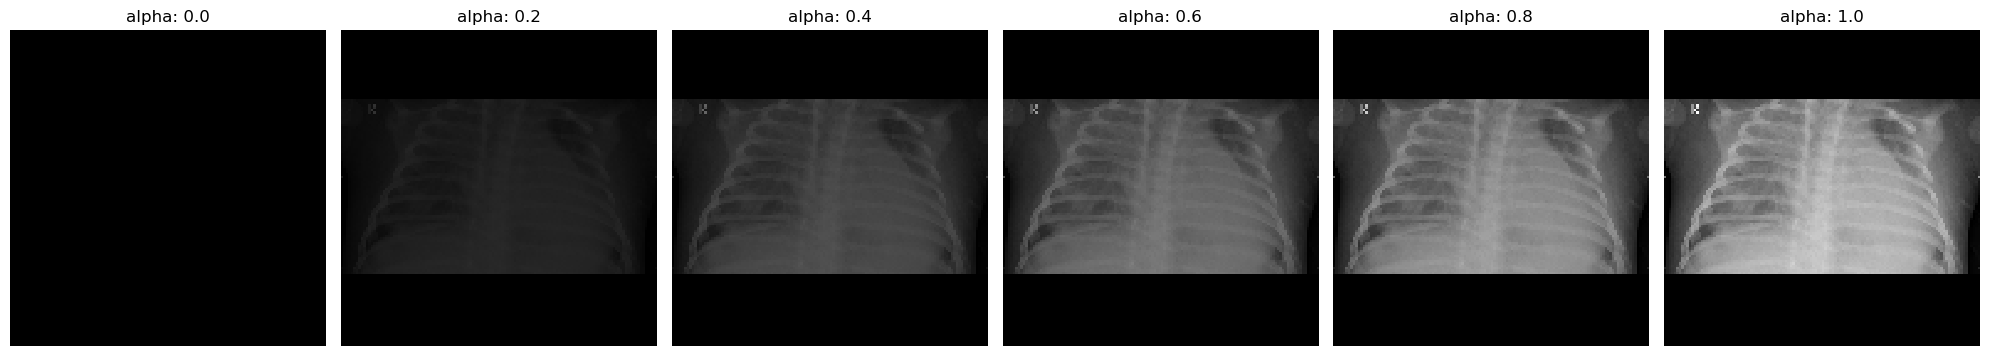

In [32]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

In [36]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model_VGG16(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0)

In [39]:
pred = model_VGG16(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

In [41]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)

In [43]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.    
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [44]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [45]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors,
                                       target_class_idx=0,
                                       m_steps=240)

In [48]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

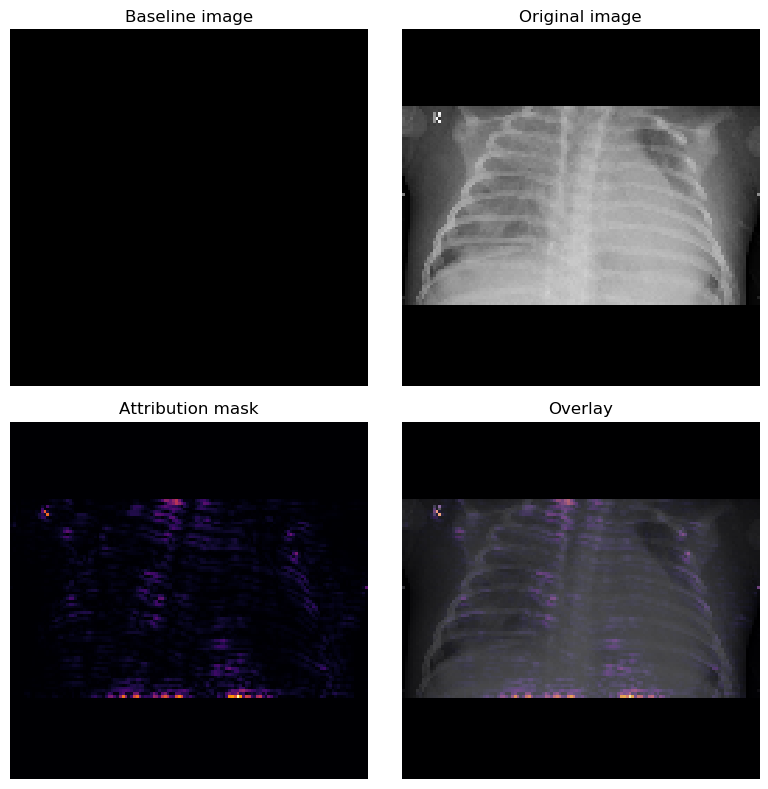

In [61]:
_ = plot_img_attributions(image=img_name_tensors,
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)
#f = plt.gcf()
#plt.savefig('figures/plot5.png')